# Tractament i Anàlisi de les Dades

Aquest *notebook* està dedicat a fer el tractament i corresponent anàlisi de les dades dels entrenaments de ciclisme.
Primer tractarem les dades, passarem de la versió original (*raw data*) a una versió més senzilla i intuitiva amb les dades rellevants per als futurs experiments.
Una vegada tractades, les modificarem per fer-les encara més visuals i fàcils d'interpretar.
Després passarem a la part de l'anàlisi, on comprovarem mitjançant gràfics i algun test com es relacionen les dades.

In [1]:
# Llibreries que farem servir en aquest notebook

import os  # Gestionar operacions amb el sistema operatiu
import glob  # Treballar amb patrons de noms de fitxers
import re
import random
import pandas as pd  # Manipulació i anàlisi de dades
import matplotlib.pyplot as plt  # Creació de gràfics
import numpy as np  # Càlcul numèric i operacions amb arrays
from pathlib import Path
from datetime import datetime
import seaborn as sns
from scipy import stats


## Tractament de les Dades

Primer extraurem la informació rellevant del nostre fitxer original.
Els entrenament són sèries temporals guardades en fitxers .csv, pertant hem de mantenir l'ordre en que venen aquests fitxers.

In [4]:
# Directori on es troben els fitxers d'entrenament en format CSV
input_folder = "raw_csv"
output_folder = "files_csv"
graphs = "graphs_analysis"

Per tractar les dades farem servir les següents funcions, les col·loquem a una cel·la apart per aconseguir que el codi sigui més intuitiu.

In [6]:
def convert_to_float(df, column_name):
    """Funció per convertir una columna a float64 amb neteja prèvia"""
    try:
        # Primer intent: conversió directa
        df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
        
        # Si hi ha molts valors NA, provem neteja més agressiva
        if df[column_name].isna().mean() > 0.3:  # Si més del 30% són NA
            print(f"Netegem caràcters no numèrics a {column_name}")
            df[column_name] = (
                df[column_name].astype(str)
                .str.replace(r'[^\d\.\-]', '', regex=True)  # Elimina tot excepte digits, . i -
                .replace('', np.nan)  # Strings buits a NaN
            )
            df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
        
        return df[column_name].astype('float64')
    except Exception as e:
        print(f"Error greu en convertir {column_name}: {str(e)}")
        return df[column_name]  # Retorna la columna original si falla tot

# Funció per convertir amb arrodoniment i gestió de valors nuls
def convert_to_int_with_round(series):
    return series.round().astype('Int64')  # Int64 permet valors NA

def generar_nom_legible(file_path, counter=1):
    """Genera un nom de fitxer llegible a partir de l'original"""
    
    # Obtenir el nom del fitxer sense extensió
    original_name = Path(file_path).stem
    
    # Extreure components amb expressions regulars
    match = re.match(r'tp-\d+\.(\d{4}-\d{2}-\d{2}).*?\.GarminPing\.(\w+)', original_name)
    
    if match:
        data_str, codi = match.groups()
        data = datetime.strptime(data_str, "%Y-%m-%d")
        data_formatted = data.strftime("%Y_%m_%d")
        return f"cycling_{data_formatted}_{counter}"
    else:
        # Si no coincideix el patró, tornar un nom genèric
        return f"cycling_{datetime.now().strftime('%Y_%m_%d')}_entrenament{counter}"


En la següent passa el que farem serà extreure la informació rellevant del fitxer original però no la modificarem, simplement netejarem les dades, treurem el que és irrellevant i ho deixarem en el seu format pertinent.

In [8]:
# Crear la carpeta de sortida si no existeix
Path(output_folder).mkdir(exist_ok=True)

# Llistar tots els .csv de la carpeta d'entrada
file_list = glob.glob(os.path.join(input_folder, '*.csv'))

# Diccionari per comptar entrenaments per dia
# Això ens servirà quan guardem el fitxer modificat
entrenaments_per_dia = {}

for file in file_list:
    try:
        data = pd.read_csv(file, low_memory=False)

        # Filtrar les entrades amb informació
        filtered_data = data[
            (data['Field 12'].astype(str) == "heart_rate") & 
            (pd.to_numeric(data['Value 4'], errors='coerce') != 1) & 
            (pd.notnull(data['Value 4']))
        ].copy()

        # Renombrar les variables
        final_data = filtered_data.rename(columns={
            'Value 1': 'timestamp',
            'Value 12': 'heart_rate',
            'Value 13': 'cadence',
            'Value 4': 'distance',
            'Value 8': 'power',
            'Value 14': 'temperature',
            'Value 7': 'speed',
            'Value 6': 'altitude'
        })[[
            'timestamp', 'heart_rate', 'cadence', 'distance',
            'power', 'temperature', 'speed', 'altitude'
        ]].copy()

        # Convertir totes les dades a un nombre real
        final_data['distance'] = convert_to_float(final_data, 'distance')
        final_data['power'] = convert_to_float(final_data, 'power')
        final_data['timestamp'] = convert_to_float(final_data, 'timestamp')

        # Llista de columnes a convertir a enter
        int_columns = ['heart_rate', 'cadence', 'power', 'temperature', 'altitude']

        # Aplicar la conversió a les columnes específiques
        for col in int_columns:
            if col in final_data.columns:
                final_data[col] = convert_to_int_with_round(final_data[col])
            else:
                print(f"Avís: La columna {col} no existeix al DataFrame")

        # Convertir timestamp a datetime i establir com a índex
        final_data['timestamp'] = pd.to_datetime(final_data['timestamp'], unit='s')
        final_data.set_index('timestamp', inplace=True)
        
        # Diferència d'altitud entre mostres consecutives
        final_data['alt_difference'] = final_data['altitude'] - final_data['altitude'].shift(1)
        
        # Mitjana mòbil de la diferència d'altitud (5 mostres)
        final_data['rolling_ave_alt'] = final_data['alt_difference'].rolling(window=5).mean()
        
        # Omplir valors NaN (generats pels cálculs de rolling)
        final_data = final_data.bfill()
        
        # Restablir l'índex per guardar-ho com a CSV estàndard
        final_data.reset_index(inplace=True)

        # Verificar si el DataFrame està buit
        if final_data.empty or final_data.dropna().empty:
            print(f"Fitxer sense dades útils eliminat: {Path(file).name}")
            continue

        # Generar el nou nom
        data_str = re.search(r'\.(\d{4}-\d{2}-\d{2})', Path(file).stem).group(1)
        entrenaments_per_dia[data_str] = entrenaments_per_dia.get(data_str, 0) + 1
        nou_nom = generar_nom_legible(file, entrenaments_per_dia[data_str])
        
        # Guardar
        output_file = os.path.join(output_folder, f"{nou_nom}.csv")
        final_data.to_csv(output_file, index=False)
        print(f"Fitxer guardat com: {output_file}")
                    
    except Exception as e:
        print(f"Error en processar el fitxer {file}: {str(e)}")

Fitxer guardat com: files_csv\cycling_2024_08_06_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_08_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_09_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_10_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_13_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_18_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_20_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_21_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_22_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_26_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_28_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_29_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_30_1.csv
Fitxer guardat com: files_csv\cycling_2024_08_31_1.csv
Fitxer guardat com: files_csv\cycling_2024_09_02_1.csv
Fitxer guardat com: files_csv\cycling_2024_09_03_1.csv
Fitxer guardat com: files_csv\cycling_2024_09_05_1.csv
Fitxer guardat com: files_csv\cycling_2024_09_06_1.csv
Fitxer gua

- Arreglar els timestamps
- afegir lo de la finestra temporal a la potència per minimitzar la variància

### Anàlisi Exploratori

Ara farem un petit anàlisi per comprovar com em extret les dades i si es necessari fer alguna modificació extra.
L'anàlisi serà senzill, simplement i imprimirem algunes gràfiques de les variables que volem

🔍 Analitzant el fitxer: cycling_2024_08_31_1.csv

✅ Fitxer carregat correctament

📊 Informació bàsica:
- Nombre de registres: 7881
- Nombre de variables: 10
- Interval temporal: 2004-09-01 06:57:10 a 2004-09-01 09:43:31

🧮 Estadístiques descriptives:
       heart_rate  cadence  distance    power  temperature    speed  altitude  \
count     7881.00  7881.00   7881.00  7881.00      7881.00  7881.00   7881.00   
mean       126.21    77.77  30294.87   179.61        28.72     8.31     99.27   
std         12.10    16.12  19000.48    82.02         3.58     2.17     23.18   
min         77.00     0.00     17.80     0.00        23.00     0.00     44.00   
25%        121.00    78.00  13604.02   149.00        27.00     6.78     85.00   
50%        127.00    82.00  29303.54   185.00        28.00     8.16    105.00   
75%        133.00    85.00  46028.92   218.00        31.00     9.85    120.00   
max        180.00   103.00  66146.05  1172.00       158.00    15.49    132.00   

       alt_differen

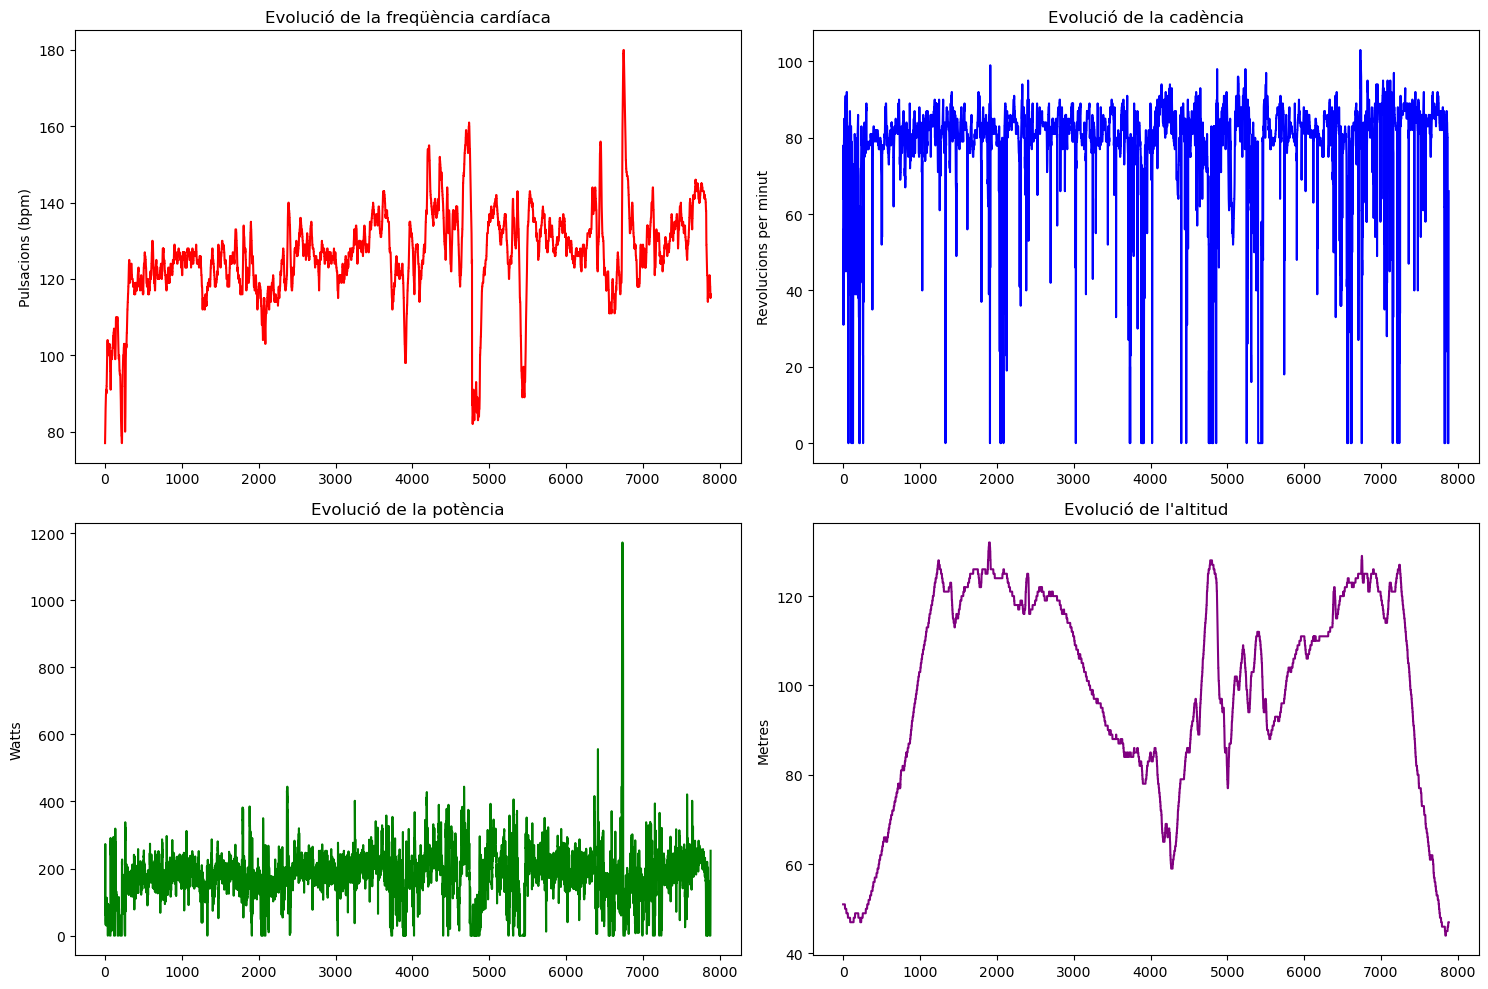


🔎 Qualitat de les dades:
- Valors nuls per variable:
timestamp          0
heart_rate         0
cadence            0
distance           0
power              0
temperature        0
speed              0
altitude           0
alt_difference     0
rolling_ave_alt    0
dtype: int64

- Valors únics per variable categòrica:
temperature: 19 valors únics


In [10]:
# 1. Seleccionar un fitxer a l'atzar
carpeta = "files_csv"
fitxers = [f for f in os.listdir(carpeta) if f.endswith('.csv')]
fitxer_triat = random.choice(fitxers)
path_complet = os.path.join(carpeta, fitxer_triat)

print(f"🔍 Analitzant el fitxer: {fitxer_triat}\n")

# 2. Carregar les dades
try:
    df = pd.read_csv(path_complet)
    print("✅ Fitxer carregat correctament\n")
    
    # 3. Anàlisi bàsic
    print("📊 Informació bàsica:")
    print(f"- Nombre de registres: {len(df)}")
    print(f"- Nombre de variables: {len(df.columns)}")
    print(f"- Interval temporal: {df['timestamp'].min()} a {df['timestamp'].max()}\n")
    
    print("🧮 Estadístiques descriptives:")
    print(df.describe().round(2))
    
    # 4. Visualitzacions
    plt.figure(figsize=(15, 10))
    
    # Gràfic de freqüència cardíaca
    plt.subplot(2, 2, 1)
    plt.plot(df['heart_rate'], color='red')
    plt.title('Evolució de la freqüència cardíaca')
    plt.ylabel('Pulsacions (bpm)')
    
    # Gràfic de cadència
    plt.subplot(2, 2, 2)
    plt.plot(df['cadence'], color='blue')
    plt.title('Evolució de la cadència')
    plt.ylabel('Revolucions per minut')
    
    # Gràfic de potència
    plt.subplot(2, 2, 3)
    plt.plot(df['power'], color='green')
    plt.title('Evolució de la potència')
    plt.ylabel('Watts')
    
    # Gràfic d'altitud
    plt.subplot(2, 2, 4)
    plt.plot(df['altitude'], color='purple')
    plt.title('Evolució de l\'altitud')
    plt.ylabel('Metres')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Anàlisi de qualitat de dades
    print("\n🔎 Qualitat de les dades:")
    print("- Valors nuls per variable:")
    print(df.isnull().sum())
    
    print("\n- Valors únics per variable categòrica:")
    cat_vars = ['temperature']  # Afegeix altres variables categòriques si n'hi ha
    for var in cat_vars:
        if var in df.columns:
            print(f"{var}: {df[var].nunique()} valors únics")
    
except Exception as e:
    print(f"❌ Error en analitzar el fitxer: {str(e)}")

### Correccions

Com podem veure, l'anàlisi és prou bo, encarra que podem millorar una mica el fitxer.
- Notem que el `timestamp` té uns valors molt extranys, realment les mostres estan preses cada segon, per tant, podem canviar aquesta variable per un espècie d'índex, on cada fila sigui un segon de la nostra mostra.
- Les gràfiques de cadència i potència presenten molta variància, aquesta és deguda a com es va en bici, per tant una idea per reduir-la i que la gràfica sigui més bona de llegir, és fer una finestra de 10 observacions i calcular la mitjana, així és suavitzarà la gràfica.

In [12]:
# Configuració
input_folder = "files_csv"
file_list = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

def process_file(file_path):
    """Funció per processar un fitxer individual"""
    try:
        # 1. Llegir el fitxer
        df = pd.read_csv(file_path)
        
        # 2. Verificar i convertir columnes numèriques
        for col in ['power', 'cadence']:
            if col in df.columns:
                # Convertir a numèric, tractant errors
                df[col] = pd.to_numeric(df[col], errors='coerce')
                # Assegurar tipus float (evita object)
                df[col] = df[col].astype('float64')
        
        # 3. Substituir timestamp per segons consecutius
        df['timestamp'] = range(1, len(df)+1)
        
        # 4. Suavitzar potència i cadència (versió actualitzada)
        for col in ['power', 'cadence']:
            if col in df.columns:
                # Netejar valors problemàtics
                cleaned = df[col].replace(0, pd.NA)
                
                # Convertir explícitament abans d'interpolar
                cleaned = pd.to_numeric(cleaned, errors='coerce')
                
                # Interpolació bidireccional (versió sense warnings)
                interpolated = cleaned.interpolate()
                interpolated = interpolated.ffill().bfill()
                
                # Assegurar tipus i aplicar mitjana mòbil
                df[col] = interpolated.astype('float64')
                df[f'{col}_ma'] = df[col].rolling(window=30, min_periods=1).mean()  # Nova columna amb mitjana mòbil
        
        # 5. Sobreescriure el fitxer
        df.to_csv(file_path, index=False)
        return True, ""
    
    except Exception as e:
        return False, str(e)

# Processar tots els fitxers
success_count = 0
for file_name in file_list:
    file_path = os.path.join(input_folder, file_name)
    success, error_msg = process_file(file_path)
    
    if success:
        print(f"✅ {file_name} processat correctament")
        success_count += 1
    else:
        print(f"❌ Error en {file_name}: {error_msg}")

print(f"\n📊 Resultat final: {success_count}/{len(file_list)} fitxers processats")

✅ cycling_2024_08_06_1.csv processat correctament
✅ cycling_2024_08_08_1.csv processat correctament
✅ cycling_2024_08_09_1.csv processat correctament
✅ cycling_2024_08_10_1.csv processat correctament
✅ cycling_2024_08_13_1.csv processat correctament
✅ cycling_2024_08_18_1.csv processat correctament
✅ cycling_2024_08_20_1.csv processat correctament
✅ cycling_2024_08_21_1.csv processat correctament
✅ cycling_2024_08_22_1.csv processat correctament
✅ cycling_2024_08_26_1.csv processat correctament
✅ cycling_2024_08_28_1.csv processat correctament
✅ cycling_2024_08_29_1.csv processat correctament
✅ cycling_2024_08_30_1.csv processat correctament
✅ cycling_2024_08_31_1.csv processat correctament
✅ cycling_2024_09_02_1.csv processat correctament
✅ cycling_2024_09_03_1.csv processat correctament
✅ cycling_2024_09_05_1.csv processat correctament
✅ cycling_2024_09_06_1.csv processat correctament
✅ cycling_2024_09_08_1.csv processat correctament
✅ cycling_2024_09_10_1.csv processat correctament


In [18]:
import os
import pandas as pd
from pathlib import Path

# Configuració
input_folder = "files_csv"
file_list = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

def process_file(file_path):
    """Funció per processar un fitxer individual"""
    try:
        # 1. Llegir el fitxer
        df = pd.read_csv(file_path)
        
        # 2. Verificar i convertir columnes numèriques
        for col in ['power', 'cadence']:
            if col in df.columns:
                # Convertir a numèric, tractant errors
                df[col] = pd.to_numeric(df[col], errors='coerce')
                # Assegurar tipus float (evita object)
                df[col] = df[col].astype('float64')
        
        # 3. Substituir timestamp per segons consecutius
        df['timestamp'] = range(1, len(df)+1)
        
        # 4. Suavitzar potència i cadència (versió actualitzada)
        for col in ['power', 'cadence']:
            if col in df.columns:
                # Netejar valors problemàtics
                cleaned = df[col].replace(0, pd.NA)
                
                # Convertir explícitament abans d'interpolar
                cleaned = pd.to_numeric(cleaned, errors='coerce')
                
                # Interpolació bidireccional (versió sense warnings)
                interpolated = cleaned.interpolate()
                interpolated = interpolated.ffill().bfill()
                
                # Assegurar tipus i aplicar mitjana mòbil
                df[col] = interpolated.astype('float64')
                df[col] = df[col].rolling(window=10, min_periods=1).mean()
        
        # 5. Sobreescriure el fitxer
        df.to_csv(file_path, index=False)
        return True, ""
    
    except Exception as e:
        return False, str(e)

# Processar tots els fitxers
success_count = 0
for file_name in file_list:
    file_path = os.path.join(input_folder, file_name)
    success, error_msg = process_file(file_path)
    
    if success:
        print(f"✅ {file_name} processat correctament")
        success_count += 1
    else:
        print(f"❌ Error en {file_name}: {error_msg}")

print(f"\n📊 Resultat final: {success_count}/{len(file_list)} fitxers processats")

✅ cycling_2024_08_06_1.csv processat correctament
✅ cycling_2024_08_08_1.csv processat correctament
✅ cycling_2024_08_09_1.csv processat correctament
✅ cycling_2024_08_10_1.csv processat correctament
✅ cycling_2024_08_13_1.csv processat correctament
✅ cycling_2024_08_18_1.csv processat correctament
✅ cycling_2024_08_20_1.csv processat correctament
✅ cycling_2024_08_21_1.csv processat correctament
✅ cycling_2024_08_22_1.csv processat correctament
✅ cycling_2024_08_26_1.csv processat correctament
✅ cycling_2024_08_28_1.csv processat correctament
✅ cycling_2024_08_29_1.csv processat correctament
✅ cycling_2024_08_30_1.csv processat correctament
✅ cycling_2024_08_31_1.csv processat correctament
✅ cycling_2024_09_02_1.csv processat correctament
✅ cycling_2024_09_03_1.csv processat correctament
✅ cycling_2024_09_05_1.csv processat correctament
✅ cycling_2024_09_06_1.csv processat correctament
✅ cycling_2024_09_08_1.csv processat correctament
✅ cycling_2024_09_10_1.csv processat correctament


## Anàlisi Exploratori

Una vegada tenim les dades tractades i modificades, podem tornar a realitzar l'anàlisi anterior però aquesta vegada en més profunditat.
El que primer farem serà imprimir uns quans gràfics per tenir una idea general de les dades que tenim.

🔍 Analitzant el fitxer: cycling_2024_08_06_1.csv

✅ Fitxer carregat correctament

📊 Informació bàsica:
- Nombre de registres: 7244
- Nombre de variables: 12
- Interval temporal: 1 a 7244

🧮 Estadístiques descriptives:
       timestamp  heart_rate  cadence  distance    power  temperature  \
count    7244.00     7244.00  7244.00   7244.00  7244.00      7244.00   
mean     3622.50      157.34    81.33  31724.52   220.80        30.74   
std      2091.31       13.58    11.52  19002.24    73.84         2.24   
min         1.00       87.00    11.00      6.19     1.00        -4.00   
25%      1811.75      153.00    81.00  14954.48   191.00        30.00   
50%      3622.50      160.00    84.00  31719.84   226.00        31.00   
75%      5433.25      166.00    87.00  47762.87   255.00        31.00   
max      7244.00      191.00   101.00  65163.24   695.00        36.00   

         speed  altitude  alt_difference  rolling_ave_alt  power_ma  \
count  7244.00   7244.00         7244.00          724

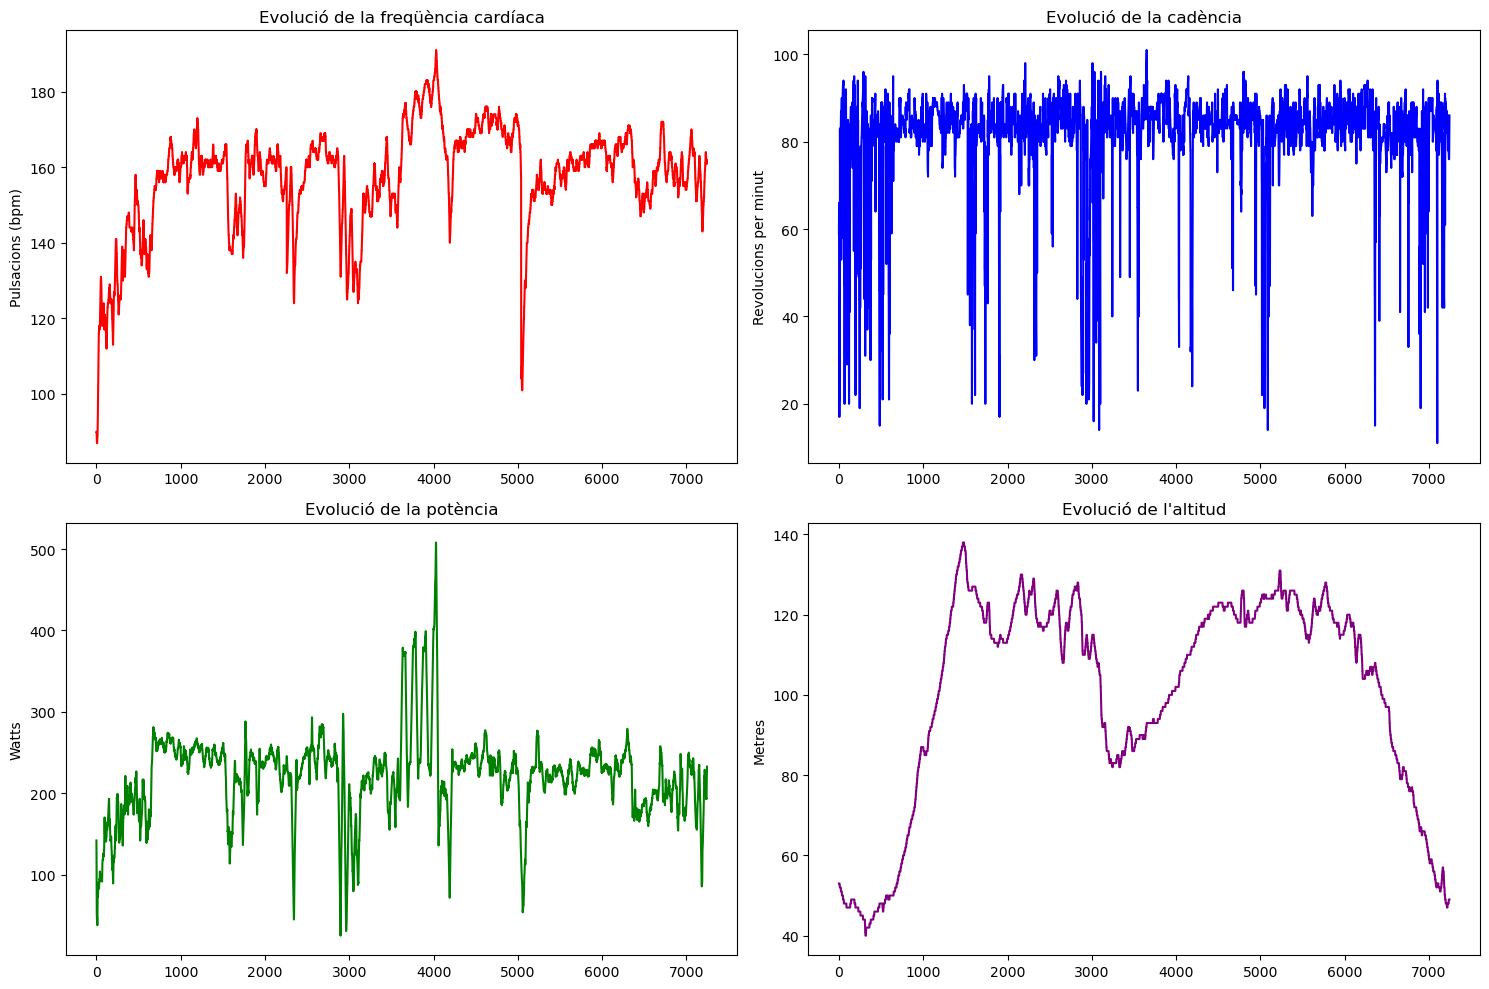

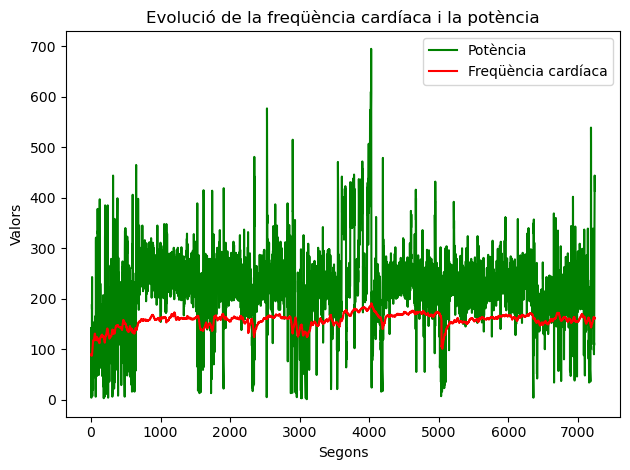

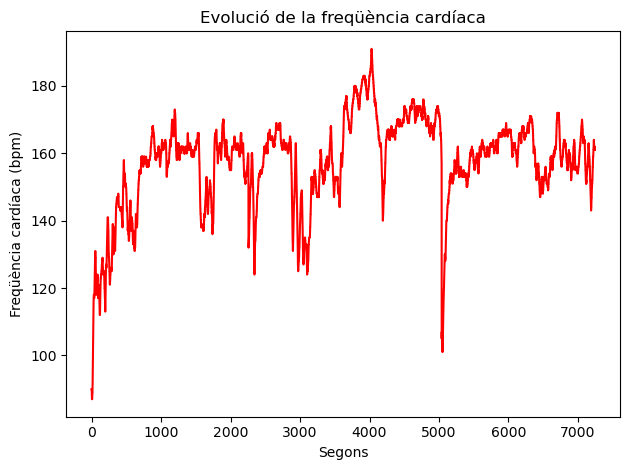


🔎 Qualitat de les dades:
- Valors nuls per variable:
timestamp          0
heart_rate         0
cadence            0
distance           0
power              0
temperature        0
speed              0
altitude           0
alt_difference     0
rolling_ave_alt    0
power_ma           0
cadence_ma         0
dtype: int64

- Valors únics per variable categòrica:
temperature: 11 valors únics


In [16]:
# 1. Seleccionar un fitxer a l'atzar
carpeta = "files_csv"
fitxers = [f for f in os.listdir(carpeta) if f.endswith('.csv')]
fitxer_triat = random.choice(fitxers)
path_complet = os.path.join(carpeta, fitxer_triat)

print(f"🔍 Analitzant el fitxer: {fitxer_triat}\n")

# 2. Carregar les dades
try:
    df = pd.read_csv(path_complet)
    print("✅ Fitxer carregat correctament\n")
    
    # 3. Anàlisi bàsic
    print("📊 Informació bàsica:")
    print(f"- Nombre de registres: {len(df)}")
    print(f"- Nombre de variables: {len(df.columns)}")
    print(f"- Interval temporal: {df['timestamp'].min()} a {df['timestamp'].max()}\n")
    
    print("🧮 Estadístiques descriptives:")
    print(df.describe().round(2))
    
    # 4. Visualitzacions
    plt.figure(figsize=(15, 10))
    
    # Gràfic de freqüència cardíaca
    plt.subplot(2, 2, 1)
    plt.plot(df['heart_rate'], color='red')
    plt.title('Evolució de la freqüència cardíaca')
    plt.ylabel('Pulsacions (bpm)')
    
    # Gràfic de cadència
    plt.subplot(2, 2, 2)
    plt.plot(df['cadence'], color='blue')
    plt.title('Evolució de la cadència')
    plt.ylabel('Revolucions per minut')
    
    # Gràfic de potència
    plt.subplot(2, 2, 3)
    plt.plot(df['power_ma'], color='green')
    plt.title('Evolució de la potència')
    plt.ylabel('Watts')
    
    # Gràfic d'altitud
    plt.subplot(2, 2, 4)
    plt.plot(df['altitude'], color='purple')
    plt.title('Evolució de l\'altitud')
    plt.ylabel('Metres')
    
    plt.tight_layout()
    plt.show()

    # Gràfica 2: Comparativa cadència i altitud
    plt.plot(df['timestamp'], df['power'], label='Potència', color='green')
    plt.plot(df['timestamp'], df['heart_rate'], label='Freqüència cardíaca', color='red')
    plt.xlabel('Segons')
    plt.ylabel('Valors')
    plt.title('Evolució de la freqüència cardíaca i la potència')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    plt.plot(df['heart_rate'], color='red')
    plt.title('Evolució de la freqüència cardíaca')
    plt.ylabel('Freqüència cardíaca (bpm)')
    plt.xlabel('Segons')

    plt.tight_layout()
    plt.savefig("heart_rate.pdf", format="pdf", bbox_inches='tight', dpi=300)
    plt.show()
    
    # 5. Anàlisi de qualitat de dades
    print("\n🔎 Qualitat de les dades:")
    print("- Valors nuls per variable:")
    print(df.isnull().sum())
    
    print("\n- Valors únics per variable categòrica:")
    cat_vars = ['temperature']  # Afegeix altres variables categòriques si n'hi ha
    for var in cat_vars:
        if var in df.columns:
            print(f"{var}: {df[var].nunique()} valors únics")
    
except Exception as e:
    print(f"❌ Error en analitzar el fitxer: {str(e)}")

In [18]:
# Configuració
input_folder = "files_csv"
output_file = "concatenate_data.csv"
file_list = [f for f in os.listdir(input_folder) if f.endswith('.csv')]

# Llista per emmagatzemar tots els DataFrames
all_data = []

for file_name in file_list:
    try:
        # Llegir el fitxer
        file_path = os.path.join(input_folder, file_name)
        df = pd.read_csv(file_path)
        
        # Afegir columna amb el nom del fitxer (sense extensió)
        df['source_file'] = os.path.splitext(file_name)[0]
        
        # Afegir a la llista
        all_data.append(df)
        print(f"✅ {file_name} afegit correctament")
        
    except Exception as e:
        print(f"❌ Error en processar {file_name}: {str(e)}")

# Concatenar tots els DataFrames
if all_data:
    concatenated_df = pd.concat(all_data, ignore_index=True)
    
    # Guardar el resultat
    concatenated_df.to_csv(output_file, index=False)
    print(f"\n📊 S'han concatenat {len(all_data)} fitxers amb èxit")
    print(f"📁 Fitxer resultant guardat com: {output_file}")
    
    # Mostrar informació bàsica
    print("\n🔍 Informació del dataset concatenat:")
    print(f"- Total de registres: {len(concatenated_df)}")
    print(f"- Variables: {len(concatenated_df.columns)}")
    print("\n📋 Mostra de les primeres files:")
    display(concatenated_df.head())
else:
    print("⚠️ No s'han trobat fitxers vàlids per concatenar")

✅ cycling_2024_08_06_1.csv afegit correctament
✅ cycling_2024_08_08_1.csv afegit correctament
✅ cycling_2024_08_09_1.csv afegit correctament
✅ cycling_2024_08_10_1.csv afegit correctament
✅ cycling_2024_08_13_1.csv afegit correctament
✅ cycling_2024_08_18_1.csv afegit correctament
✅ cycling_2024_08_20_1.csv afegit correctament
✅ cycling_2024_08_21_1.csv afegit correctament
✅ cycling_2024_08_22_1.csv afegit correctament
✅ cycling_2024_08_26_1.csv afegit correctament
✅ cycling_2024_08_28_1.csv afegit correctament
✅ cycling_2024_08_29_1.csv afegit correctament
✅ cycling_2024_08_30_1.csv afegit correctament
✅ cycling_2024_08_31_1.csv afegit correctament
✅ cycling_2024_09_02_1.csv afegit correctament
✅ cycling_2024_09_03_1.csv afegit correctament
✅ cycling_2024_09_05_1.csv afegit correctament
✅ cycling_2024_09_06_1.csv afegit correctament
✅ cycling_2024_09_08_1.csv afegit correctament
✅ cycling_2024_09_10_1.csv afegit correctament
✅ cycling_2024_09_11_1.csv afegit correctament
✅ cycling_202

,timestamp,heart_rate,cadence,distance,power,temperature,speed,altitude,alt_difference,rolling_ave_alt,power_ma,cadence_ma,source_file
0,1,90,59.0,6.19,142.0,28,2.855,53,0,0.0,142.000000,59.000000,cycling_2024_08_06_1
1,2,90,66.0,9.70,111.0,28,3.294,53,0,0.0,126.500000,62.500000,cycling_2024_08_06_1
2,3,90,66.0,13.85,4.0,28,3.956,53,0,0.0,85.666667,63.666667,cycling_2024_08_06_1
3,4,89,66.0,18.16,4.0,28,4.022,53,0,0.0,65.250000,64.250000,cycling_2024_08_06_1
4,5,88,17.0,22.60,4.0,28,4.208,53,0,0.0,53.000000,54.800000,cycling_2024_08_06_1


### Test de correlació

En vista de la similitut entre la gràfica de `power` i de `heart_rate`, sembla una bona idea fer un test de correlació per estudiar la dependència entre aquestes dues variables. 
Farem servir dos test de correlació per tenir dos enfocament complementaris:

- **Correlació de Pearson:** comprova la relació lineal entre dues variables.
- **Correlació de Spearman:** més robust davant valors extrems i funciona bé encara que les dades no estiguin normalitzades.

🔍 Analitzant el fitxer: cycling_2024_08_30_1.csv



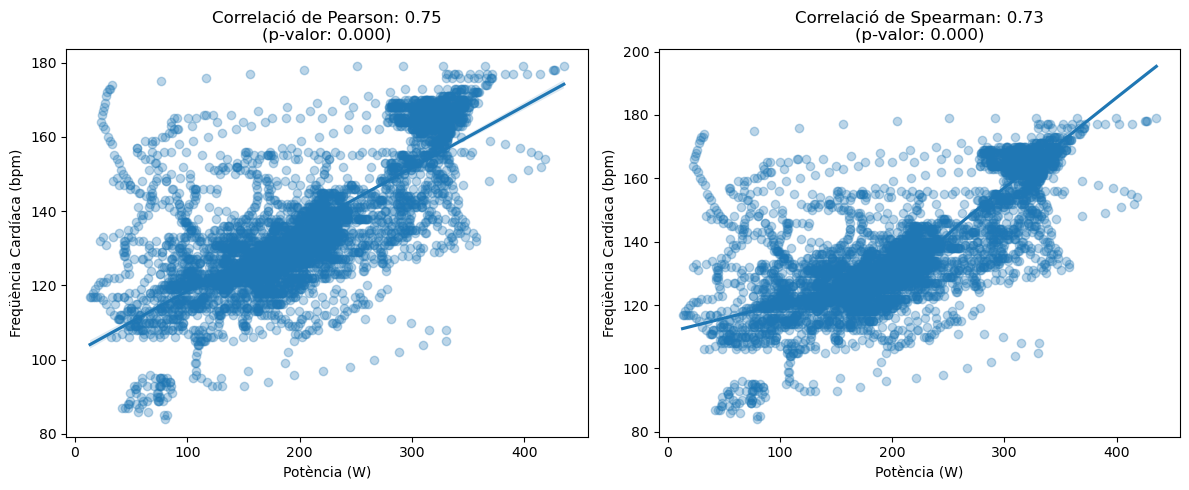


📝 Interpretació preliminar:
- Correlació lineal (Pearson): 0.75
  (Valor proper a 1 = relació lineal positiva forta)
- Correlació monòtona (Spearman): 0.73
  (Valor proper a 1 = relació monòtona positiva forta)

✅ La correlació lineal és estadísticament significativa (p < 0.05)
✅ La correlació monòtona és estadísticament significativa (p < 0.05)


In [24]:
# Configuració
input_folder = "files_csv"
file_list = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
file_name = random.choice(file_list)
file_path = os.path.join(input_folder, file_name)

print(f"🔍 Analitzant el fitxer: {file_name}\n")

# 1. Carregar i preparar dades
df = pd.read_csv(file_path)

# Neteja bàsica (eliminar files amb valors nuls en aquestes variables)
df_clean = df[['heart_rate', 'power']].dropna()

# 2. Tests de correlació
# Pearson (lineal)
pearson_corr, pearson_p = stats.pearsonr(df_clean['heart_rate'], df_clean['power'])

# Spearman (monòtona)
spearman_corr, spearman_p = stats.spearmanr(df_clean['heart_rate'], df_clean['power'])

# 3. Visualització
plt.figure(figsize=(12, 5))

# Gràfic de dispersió amb regressió
plt.subplot(1, 2, 1)
sns.regplot(x='power', y='heart_rate', data=df_clean, scatter_kws={'alpha':0.3})
plt.title(f"Correlació de Pearson: {pearson_corr:.2f}\n(p-valor: {pearson_p:.3f})")
plt.xlabel("Potència (W)")
plt.ylabel("Freqüència Cardíaca (bpm)")

# Gràfic de dispersió amb tendència no paramètrica
plt.subplot(1, 2, 2)
sns.regplot(x='power', y='heart_rate', data=df_clean, 
            scatter_kws={'alpha':0.3}, lowess=True)
plt.title(f"Correlació de Spearman: {spearman_corr:.2f}\n(p-valor: {spearman_p:.3f})")
plt.xlabel("Potència (W)")
plt.ylabel("Freqüència Cardíaca (bpm)")

plt.tight_layout()
plt.show()

# 4. Interpretació dels resultats
print("\n📝 Interpretació preliminar:")
print(f"- Correlació lineal (Pearson): {pearson_corr:.2f}")
print(f"  (Valor proper a 1 = relació lineal positiva forta)")
print(f"- Correlació monòtona (Spearman): {spearman_corr:.2f}")
print(f"  (Valor proper a 1 = relació monòtona positiva forta)")

if pearson_p < 0.05:
    print("\n✅ La correlació lineal és estadísticament significativa (p < 0.05)")
else:
    print("\n❌ La correlació lineal no és estadísticament significativa")

if spearman_p < 0.05:
    print("✅ La correlació monòtona és estadísticament significativa (p < 0.05)")
else:
    print("❌ La correlació monòtona no és estadísticament significativa")

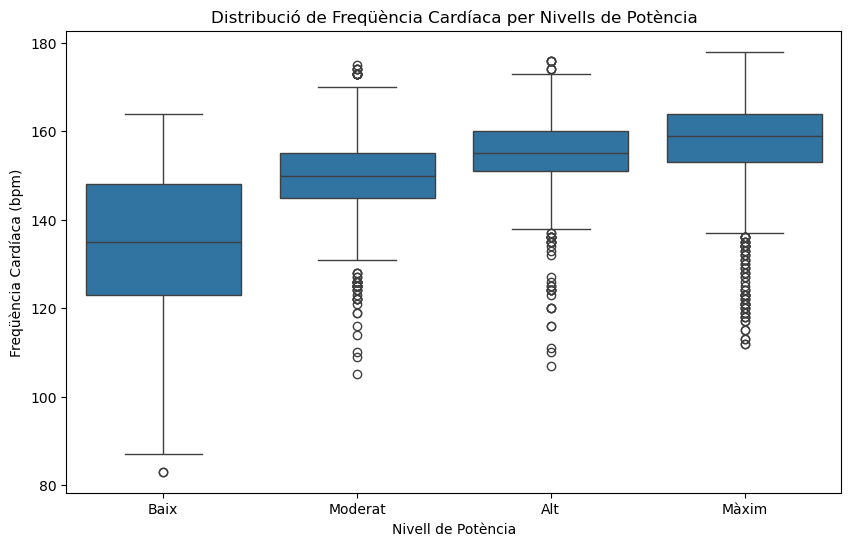

In [70]:
# Dividir en quartils de potència per veure com canvia la relació
df_clean['power_bin'] = pd.qcut(df_clean['power'], q=4, labels=['Baix', 'Moderat', 'Alt', 'Màxim'])

plt.figure(figsize=(10, 6))
sns.boxplot(x='power_bin', y='heart_rate', data=df_clean)
plt.title("Distribució de Freqüència Cardíaca per Nivells de Potència")
plt.xlabel("Nivell de Potència")
plt.ylabel("Freqüència Cardíaca (bpm)")
plt.show()

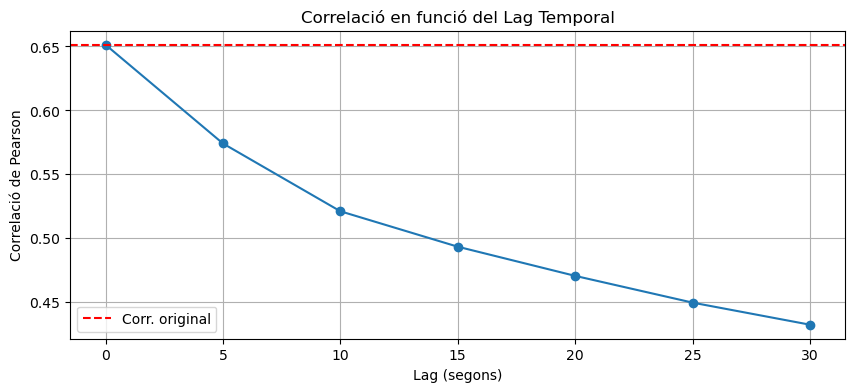

In [72]:
# Calcula correlacions amb diferents lags temporals
max_lag = 30  # segons
lags = range(0, max_lag+1, 5)
corrs = [df_clean['heart_rate'].corr(df_clean['power'].shift(-lag)) for lag in lags]

plt.figure(figsize=(10, 4))
plt.plot(lags, corrs, marker='o')
plt.axhline(y=pearson_corr, color='r', linestyle='--', label='Corr. original')
plt.title("Correlació en funció del Lag Temporal")
plt.xlabel("Lag (segons)")
plt.ylabel("Correlació de Pearson")
plt.legend()
plt.grid()
plt.show()

## Descomposició de les sèries temporals

En aquesta secció farem la descomposició de sèries temporals


🔍 Processant cycling_2024_11_15_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

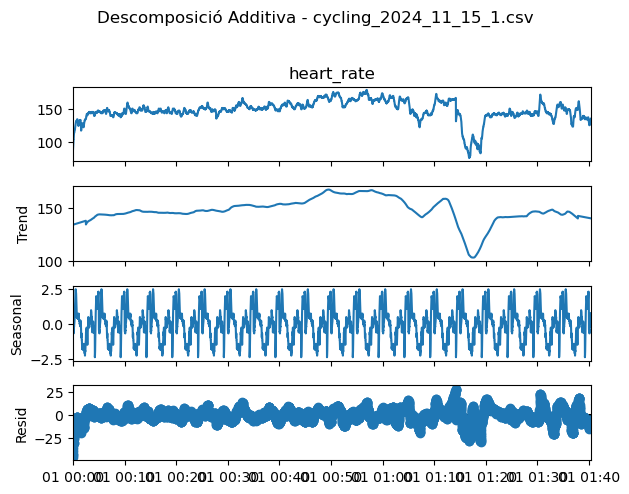

📊 Components additius guardats a decomposition_add_cycling_2024_11_15_1.csv


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

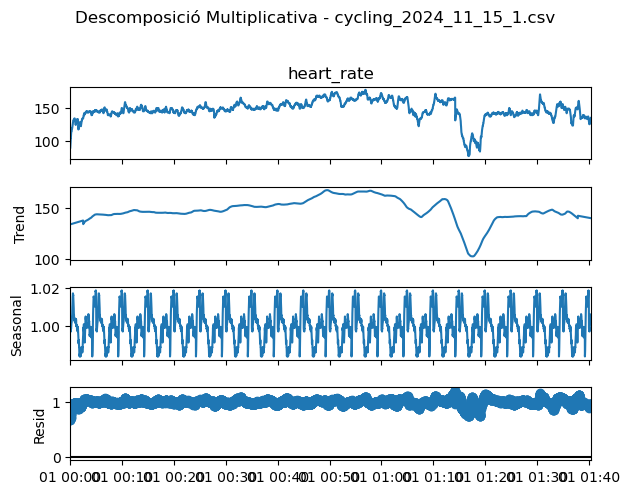

📊 Components multiplicatius guardats a decomposition_mul_cycling_2024_11_15_1.csv

🔍 Processant cycling_2024_08_13_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

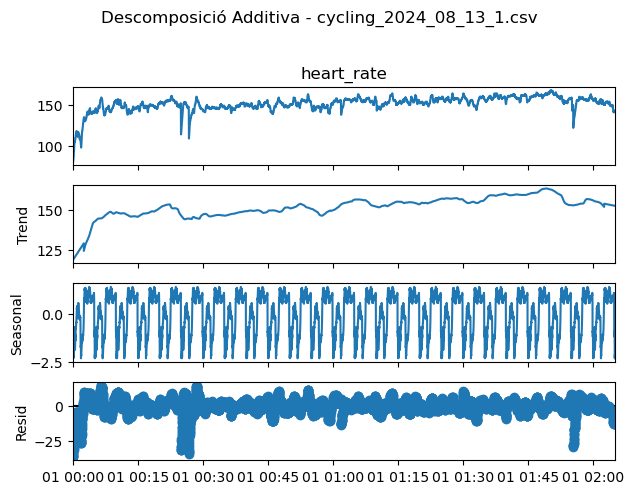

📊 Components additius guardats a decomposition_add_cycling_2024_08_13_1.csv


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

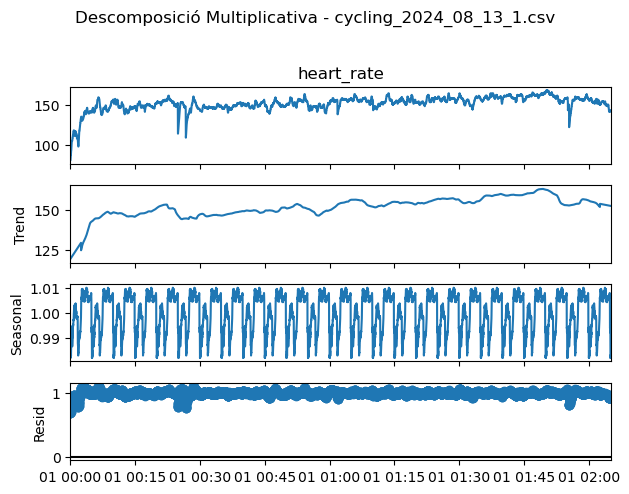

📊 Components multiplicatius guardats a decomposition_mul_cycling_2024_08_13_1.csv

🔍 Processant cycling_2024_09_25_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

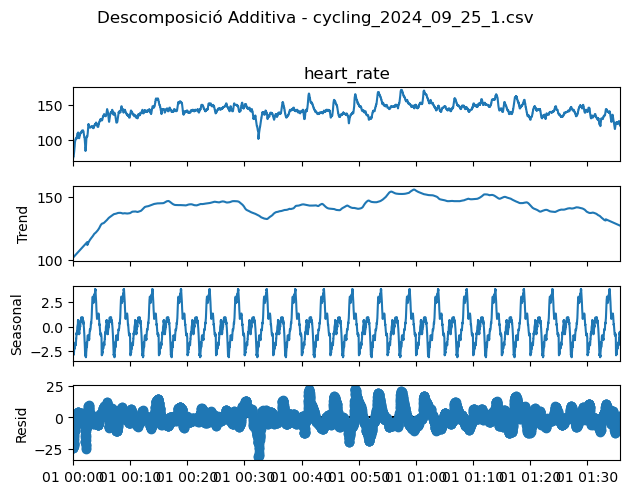

📊 Components additius guardats a decomposition_add_cycling_2024_09_25_1.csv


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

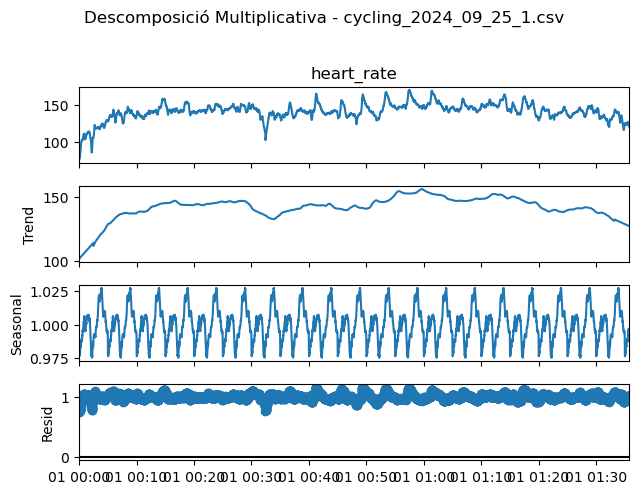

📊 Components multiplicatius guardats a decomposition_mul_cycling_2024_09_25_1.csv

🔍 Processant cycling_2024_10_24_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

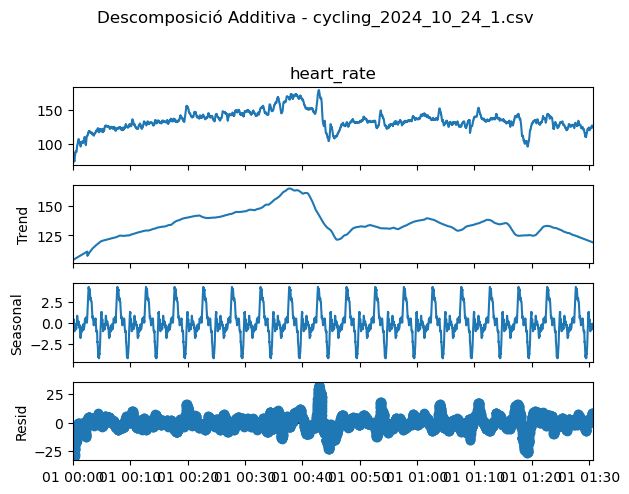

📊 Components additius guardats a decomposition_add_cycling_2024_10_24_1.csv


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

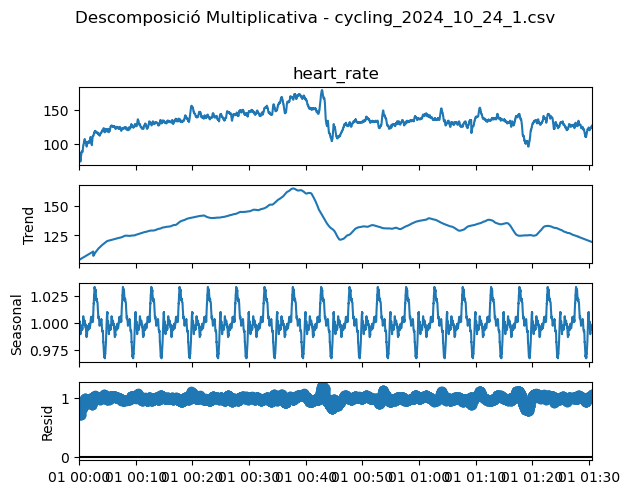

📊 Components multiplicatius guardats a decomposition_mul_cycling_2024_10_24_1.csv

🔍 Processant cycling_2024_09_15_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

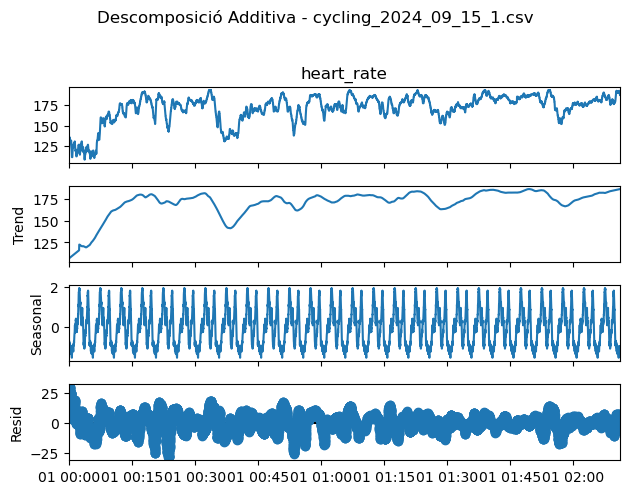

📊 Components additius guardats a decomposition_add_cycling_2024_09_15_1.csv


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\2190009794.py:28: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


<Figure size 1400x1000 with 0 Axes>

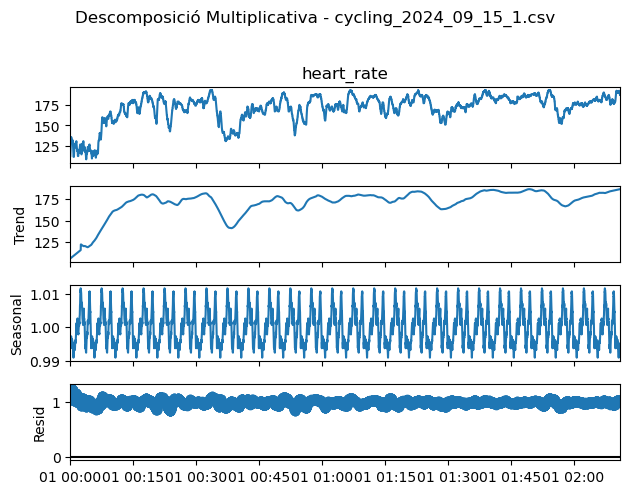

📊 Components multiplicatius guardats a decomposition_mul_cycling_2024_09_15_1.csv

✅ Anàlisi completat per als fitxers seleccionats


In [75]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import random

# Configuració
input_folder = "files_csv"
file_list = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
random_files = random.sample(file_list, min(5, len(file_list)))  # Selecciona 5 aleatoris

def decompose_heart_rate(file_path, model_type='additive'):
    """Funció per descomposar la freqüència cardíaca d'un fitxer"""
    try:
        # 1. Llegir el fitxer
        df = pd.read_csv(file_path)
        
        # 2. Verificar que existeix la columna de freqüència cardíaca
        if 'heart_rate' not in df.columns:
            return None, f"No s'ha trobat la columna 'heart_rate' al fitxer {os.path.basename(file_path)}"
        
        # 3. Netejar i preparar les dades
        hr_series = pd.to_numeric(df['heart_rate'], errors='coerce')
        hr_series = hr_series.interpolate().ffill().bfill()  # Tractament de valors faltants
        
        # 4. Crear índex temporal (assumint 1Hz de freqüència de mostreig)
        time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')
        hr_series.index = time_index
        
        # 5. Descomposició - assumim cicles de 5 minuts (300 segons) com a període estacional
        period = 300  # Ajusta segons el teu coneixement de l'entrenament
        result = seasonal_decompose(hr_series, model=model_type, period=period, extrapolate_trend='freq')
        
        return result, None
    
    except Exception as e:
        return None, str(e)

# Processar els 5 fitxers aleatoris
for file_name in random_files:
    file_path = os.path.join(input_folder, file_name)
    print(f"\n🔍 Processant {file_name}...")
    
    # Descomposició additiva
    result_add, error = decompose_heart_rate(file_path, 'additive')
    if error:
        print(f"❌ Error (additiu): {error}")
    else:
        # Visualització
        plt.figure(figsize=(14, 10))
        result_add.plot()
        plt.suptitle(f"Descomposició Additiva - {file_name}", y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Guardar components
        components_add = pd.DataFrame({
            'heart_rate': result_add.observed,
            'trend': result_add.trend,
            'seasonal': result_add.seasonal,
            'residual': result_add.resid
        })
        output_filename = f"decomposition_add_{os.path.splitext(file_name)[0]}.csv"
        components_add.to_csv(output_filename, index=False)
        print(f"📊 Components additius guardats a {output_filename}")
    
    # Descomposició multiplicativa
    result_mul, error = decompose_heart_rate(file_path, 'multiplicative')
    if error:
        print(f"❌ Error (multiplicatiu): {error}")
    else:
        # Visualització
        plt.figure(figsize=(14, 10))
        result_mul.plot()
        plt.suptitle(f"Descomposició Multiplicativa - {file_name}", y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Guardar components
        components_mul = pd.DataFrame({
            'heart_rate': result_mul.observed,
            'trend': result_mul.trend,
            'seasonal': result_mul.seasonal,
            'residual': result_mul.resid
        })
        output_filename = f"decomposition_mul_{os.path.splitext(file_name)[0]}.csv"
        components_mul.to_csv(output_filename, index=False)
        print(f"📊 Components multiplicatius guardats a {output_filename}")

print("\n✅ Anàlisi completat per als fitxers seleccionats")


🧹 Netejant cycling_2024_11_15_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\860402903.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


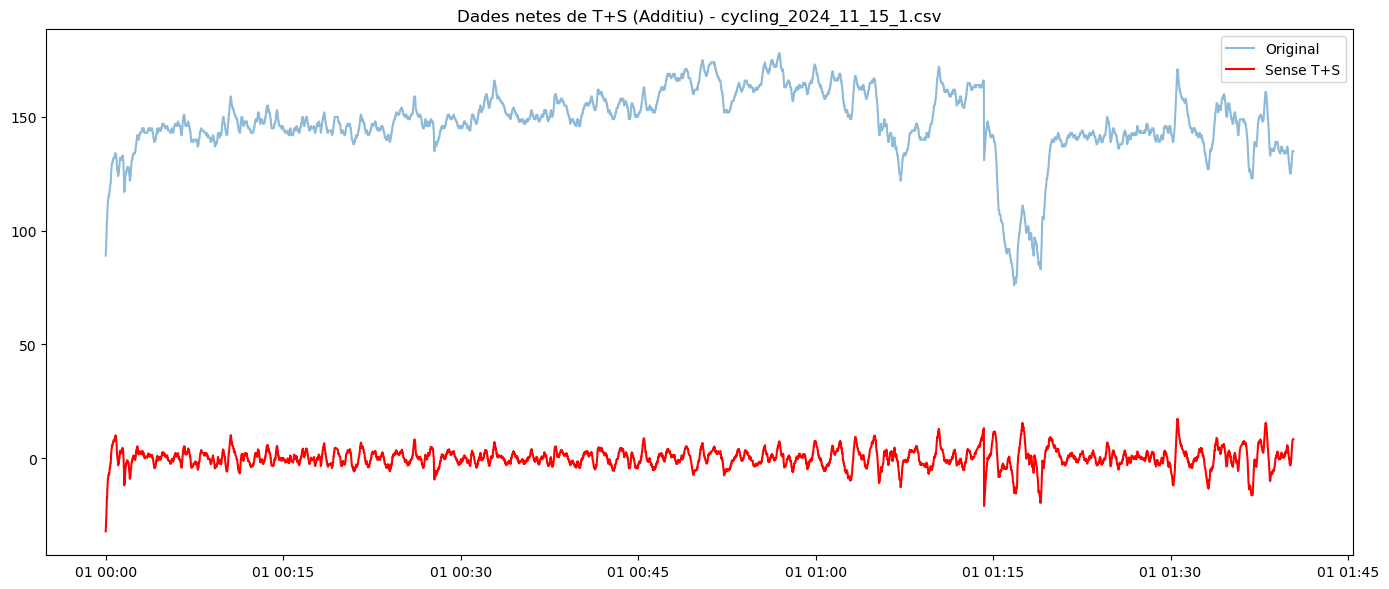

💾 Dades netes (additiu) guardades a cleaned_add_cycling_2024_11_15_1.csv

🧹 Netejant cycling_2024_08_13_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\860402903.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


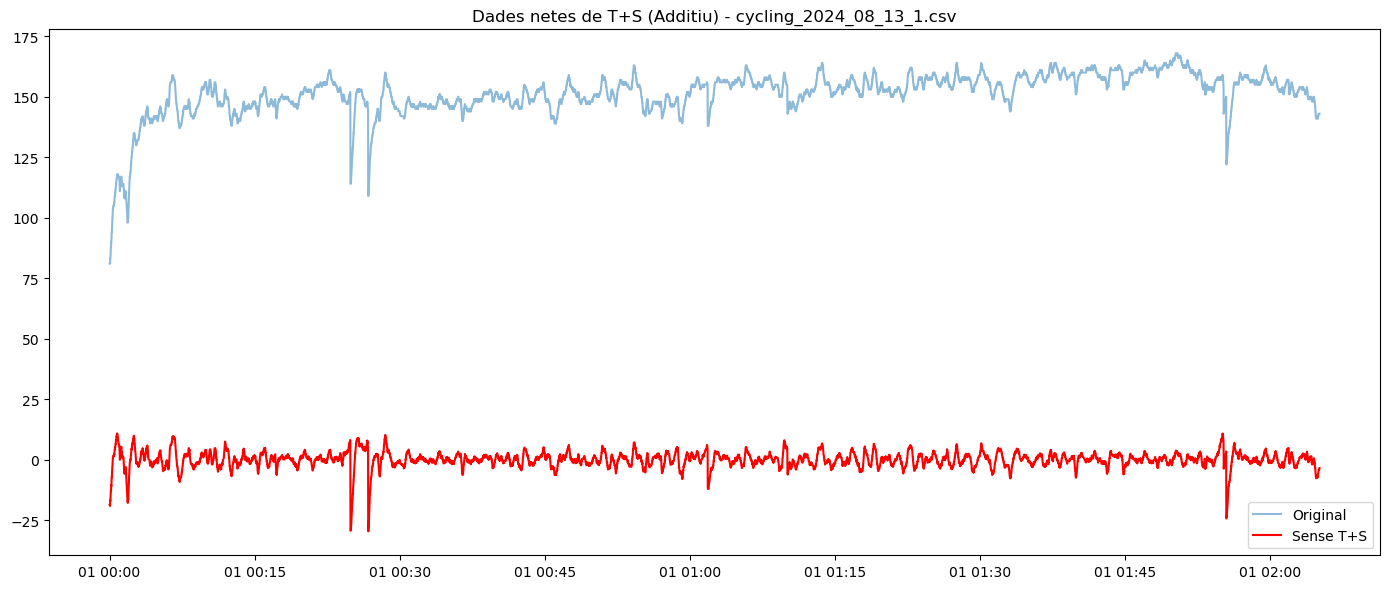

💾 Dades netes (additiu) guardades a cleaned_add_cycling_2024_08_13_1.csv

🧹 Netejant cycling_2024_09_25_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\860402903.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


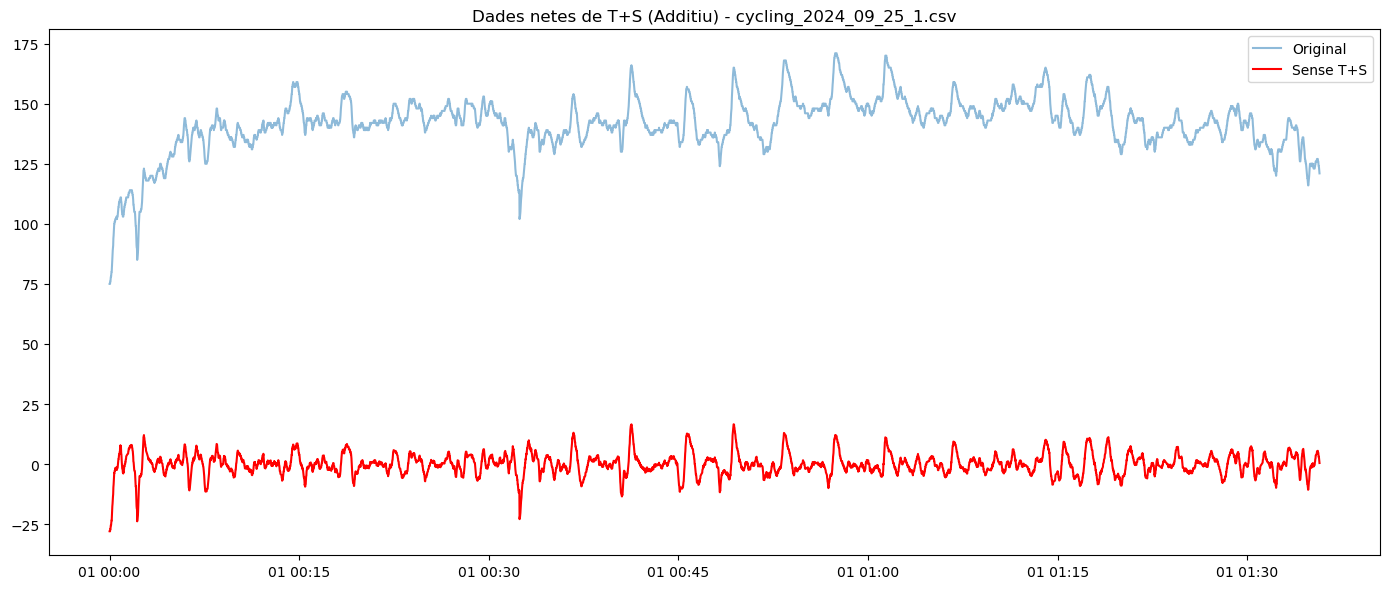

💾 Dades netes (additiu) guardades a cleaned_add_cycling_2024_09_25_1.csv

🧹 Netejant cycling_2024_10_24_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\860402903.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


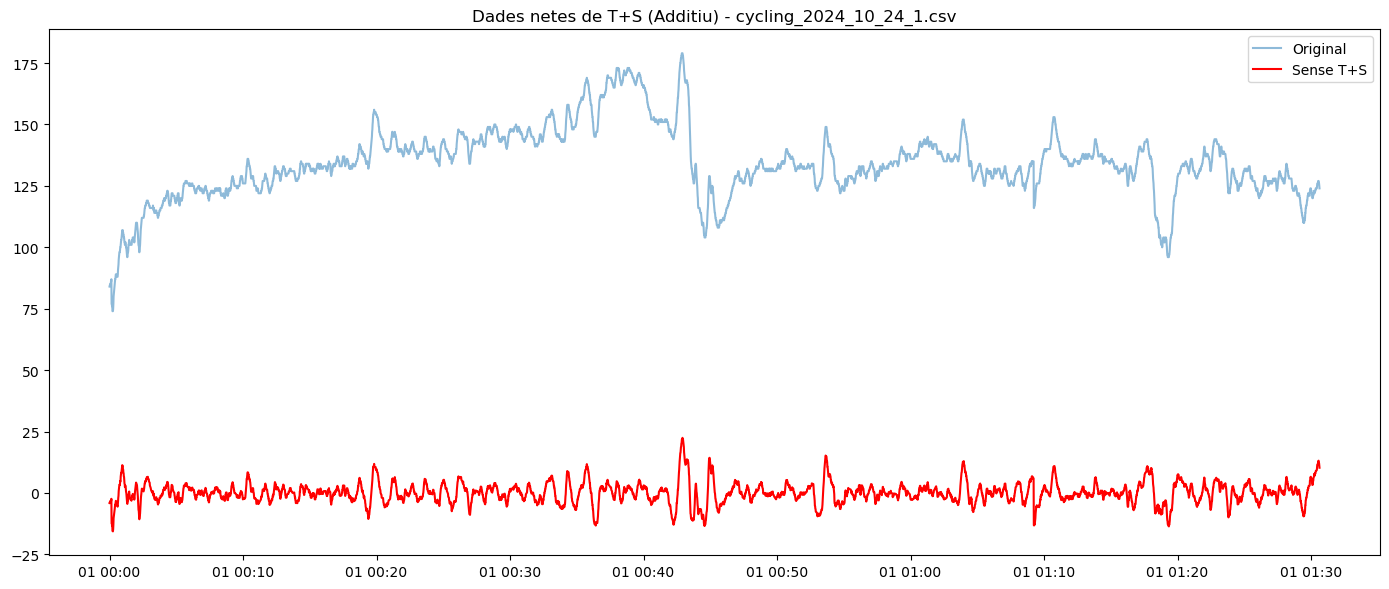

💾 Dades netes (additiu) guardades a cleaned_add_cycling_2024_10_24_1.csv

🧹 Netejant cycling_2024_09_15_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\860402903.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


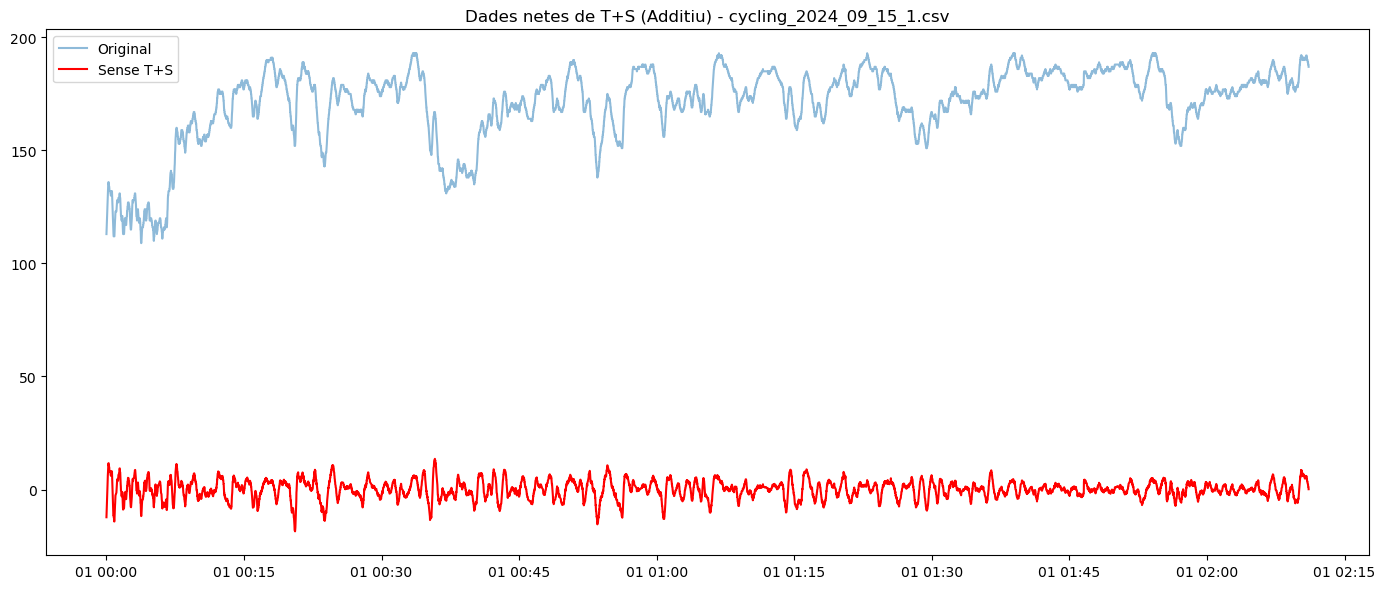

💾 Dades netes (additiu) guardades a cleaned_add_cycling_2024_09_15_1.csv


In [83]:
def remove_trend_seasonality(file_path, model_type='additive'):
    """Elimina tendència i estacionalitat utilitzant descomposició TSN"""
    try:
        # 1. Llegir i preparar les dades
        df = pd.read_csv(file_path)
        hr_series = pd.to_numeric(df['heart_rate'], errors='coerce').interpolate().ffill().bfill()
        time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')
        hr_series.index = time_index
        
        # 2. Descomposició
        period = 100  # Ajusta segons el teu cas
        decomposition = seasonal_decompose(hr_series, model=model_type, period=period, extrapolate_trend='freq')
        
        # 3. Eliminar components segons model
        if model_type == 'additive':
            cleaned = hr_series - decomposition.trend - decomposition.seasonal
        else:  # multiplicative
            cleaned = hr_series / (decomposition.trend * decomposition.seasonal)
        
        # 4. Neteja residual (opcional)
        cleaned = cleaned.interpolate().dropna()
        
        # 5. Guardar resultats
        result_df = pd.DataFrame({
            'original': hr_series,
            'cleaned': cleaned,
            'trend': decomposition.trend,
            'seasonal': decomposition.seasonal
        })
        
        return result_df, None
    
    except Exception as e:
        return None, str(e)

# Processar els mateixos 5 fitxers aleatoris
for file_name in random_files:
    file_path = os.path.join(input_folder, file_name)
    print(f"\n🧹 Netejant {file_name}...")
    
    # Provar amb model additiu
    cleaned_add, error = remove_trend_seasonality(file_path, 'additive')
    if error:
        print(f"❌ Error (additiu): {error}")
    else:
        # Visualització
        plt.figure(figsize=(14, 6))
        plt.plot(cleaned_add['original'], label='Original', alpha=0.5)
        plt.plot(cleaned_add['cleaned'], label='Sense T+S', color='red')
        plt.title(f"Dades netes de T+S (Additiu) - {file_name}")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # Guardar resultats
        output_filename = f"cleaned_add_{os.path.splitext(file_name)[0]}.csv"
        cleaned_add.to_csv(output_filename, index=False)
        print(f"💾 Dades netes (additiu) guardades a {output_filename}")

In [87]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from scipy.stats import kendalltau
import random

# Configuració de directoris
input_folder = "files_csv"
output_folder = "graphs_analysis"
os.makedirs(output_folder, exist_ok=True)

file_list = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
random_files = random.sample(file_list, min(5, len(file_list)))

def analyze_trend_seasonality(series, file_name):
    """Analitza tendència i estacionalitat amb múltiples mètodes"""
    # Crear subdirectori específic per a aquest fitxer
    file_output_folder = os.path.join(output_folder, os.path.splitext(file_name)[0])
    os.makedirs(file_output_folder, exist_ok=True)
    
    # 1. Anàlisi d'autocorrelació
    plt.figure(figsize=(14, 7))
    plot_acf(series.dropna(), lags=1000, alpha=0.05)
    plt.title(f"Autocorrelació - {file_name}")
    acf_path = os.path.join(file_output_folder, "autocorrelation.pdf")
    plt.savefig(acf_path, format='pdf', bbox_inches='tight')
    plt.close()
    
    # 2. Anàlisi espectral (FFT)
    plt.figure(figsize=(14, 7))
    fft = np.fft.fft(series.dropna().values - np.mean(series.dropna().values))
    power = np.abs(fft) ** 2
    freqs = np.fft.fftfreq(len(series.dropna()), 1/1.0)  # 1Hz sampling
    positive_mask = freqs > 0
    plt.plot(freqs[positive_mask], power[positive_mask])
    plt.title(f"Espectre de Freqüències - {file_name}")
    plt.xlabel("Freqüència (Hz)")
    plt.ylabel("Potència")
    fft_path = os.path.join(file_output_folder, "fft_analysis.pdf")
    plt.savefig(fft_path, format='pdf', bbox_inches='tight')
    plt.close()
    
    # 3. Tests d'estacionarietat
    with open(os.path.join(file_output_folder, "stationarity_tests.txt"), "w") as f:
        # Test Dickey-Fuller
        adf_result = adfuller(series.dropna())
        f.write(f"Dickey-Fuller Test:\n")
        f.write(f"Estadístic: {adf_result[0]:.4f}\n")
        f.write(f"p-valor: {adf_result[1]:.4f}\n")
        f.write(f"Valors crítics: {adf_result[4]}\n\n")
        
        # Test KPSS
        kpss_result = kpss(series.dropna(), regression='c')
        f.write(f"KPSS Test:\n")
        f.write(f"Estadístic: {kpss_result[0]:.4f}\n")
        f.write(f"p-valor: {kpss_result[1]:.4f}\n")
        f.write(f"Valors crítics: {kpss_result[3]}\n\n")
        
        # Test de Kendall per tendència
        kendall_result = kendalltau(series.dropna().index.values, series.dropna().values)
        f.write(f"Test de Kendall:\n")
        f.write(f"Coeficient: {kendall_result[0]:.4f}\n")
        f.write(f"p-valor: {kendall_result[1]:.4f}\n")
    
    return file_output_folder

def decompose_heart_rate(file_path, model_type='additive'):
    """Funció per descomposar la freqüència cardíaca d'un fitxer"""
    try:
        # 1. Llegir el fitxer
        df = pd.read_csv(file_path)
        
        # 2. Verificar que existeix la columna de freqüència cardíaca
        if 'heart_rate' not in df.columns:
            return None, f"No s'ha trobat la columna 'heart_rate' al fitxer {os.path.basename(file_path)}"
        
        # 3. Netejar i preparar les dades
        hr_series = pd.to_numeric(df['heart_rate'], errors='coerce')
        hr_series = hr_series.interpolate().ffill().bfill()
        
        # 4. Crear índex temporal
        time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')
        hr_series.index = time_index
        
        # 5. Analitzar tendència i estacionalitat
        file_name = os.path.basename(file_path)
        output_folder = analyze_trend_seasonality(hr_series, file_name)
        
        # 6. Determinar el millor període automàticament
        period = find_best_period(hr_series)
        print(f"📊 Període detectat: {period} segons")
        
        # 7. Descomposició clàssica
        result = seasonal_decompose(hr_series, model=model_type, period=period, extrapolate_trend='freq')
        
        # 8. Descomposició STL (més robusta)
        stl = STL(hr_series, period=period, robust=True)
        stl_result = stl.fit()
        
        return {
            'classic': result,
            'stl': stl_result,
            'period': period,
            'output_folder': output_folder
        }, None
    
    except Exception as e:
        return None, str(e)

def find_best_period(series, max_period=1200):
    """Determina el millor període estacional"""
    # Mètode 1: Autocorrelació
    acf = pd.Series(series).autocorr(lag=max_period//2)
    
    # Mètode 2: FFT
    fft = np.fft.fft(series.dropna().values - np.mean(series.dropna().values))
    freqs = np.fft.fftfreq(len(series.dropna()), 1/1.0)
    positive_mask = freqs > 0
    dominant_freq = freqs[positive_mask][np.argmax(np.abs(fft[positive_mask]) ** 2)]
    fft_period = int(round(1/dominant_freq)) if dominant_freq > 0 else None
    
    # Triar el període més probable
    if fft_period and 10 < fft_period < max_period:
        return fft_period
    return max_period//4  # Valor per defecte si no es detecta clarament

# Processar els fitxers
for file_name in random_files:
    file_path = os.path.join(input_folder, file_name)
    print(f"\n🔍 Processant {file_name}...")
    
    # Descomposició additiva
    result_add, error = decompose_heart_rate(file_path, 'additive')
    if error:
        print(f"❌ Error (additiu): {error}")
    else:
        # Guardar resultats descomposició clàssica
        plt.figure(figsize=(14, 10))
        result_add['classic'].plot()
        plt.suptitle(f"Descomposició Additiva - {file_name}", y=1.02)
        classic_path = os.path.join(result_add['output_folder'], "classic_decomposition.pdf")
        plt.savefig(classic_path, format='pdf', bbox_inches='tight')
        plt.close()
        
        # Guardar resultats STL
        plt.figure(figsize=(14, 10))
        result_add['stl'].plot()
        plt.suptitle(f"Descomposició STL - {file_name}", y=1.02)
        stl_path = os.path.join(result_add['output_folder'], "stl_decomposition.pdf")
        plt.savefig(stl_path, format='pdf', bbox_inches='tight')
        plt.close()
        
        print(f"📊 Resultats guardats a {result_add['output_folder']}")

print("\n✅ Anàlisi completat per als fitxers seleccionats")


🔍 Processant cycling_2024_09_10_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\566003476.py:87: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')


📊 Període detectat: 300 segons
📊 Resultats guardats a graphs_analysis\cycling_2024_09_10_1

🔍 Processant cycling_2024_08_10_1.csv...


C:\Users\alber\AppData\Local\Temp\ipykernel_11288\566003476.py:87: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_index = pd.date_range(start='2023-01-01', periods=len(hr_series), freq='S')
C:\Users\alber\AppData\Local\Temp\ipykernel_11288\566003476.py:58: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna(), regression='c')


📊 Període detectat: 300 segons


KeyboardInterrupt: 

<Figure size 1400x700 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x700 with 0 Axes>